# <center>CITS5017 Project 2<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [169]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load and Prepare Data
- `PerthA_df`: temperature data from 1944-06 to 2024-08 (total 963 months)
- `PerthM_df`: temperature data from 1994-01 to 2024-08 (total 368 months)

In [170]:
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]

def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]

    if batch_size == -1:
        batch_size = df.shape[0]

    return tf.keras.utils.timeseries_dataset_from_array(
                tf.convert_to_tensor(df, dtype=tf.float32),
                targets = None,
                sequence_length = inputs_length + targets_length,
                batch_size = batch_size,
                shuffle = shuffle,
                seed = seed
            ).map(split_inputs_and_targets)

PerthA_df, PerthM_df = load_data("temperatures.pkl")
print(f"Total Perth Airport data: {len(PerthA_df)}")
print(f"Total Perth Metro data: {len(PerthM_df)}")

Total Perth Airport data: 963
Total Perth Metro data: 368


# Part 1 Tasks
Implement three algorithms for predicting the minimum and maximum temperatures and compare their performances.

## (a) Get training, validation, and test datasets

In [171]:
def split_data_length(df, seq_lengths, train=False):
    inputs_length, targets_length = (seq_lengths)
    if train:
        ds = split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True)
    else:
        ds = split_data(df, inputs_length, targets_length, batch_size=-1, shuffle=False)
    return ds

# Separate into validation and test datasets
PerthM_val = PerthM_df.loc["1994-01":"2013-12"] # First 20 years
PerthM_test = PerthM_df.loc["2014-01":]         # Last 10 years

# Split into training, validation and test datasets
train_ds = split_data_length(PerthA_df, (72, 12), train=True)
val_ds = split_data_length(PerthM_val, (72, 12))
test_ds = split_data_length(PerthM_test, (72, 12))

# Extract X_test and y_test from the test dataset (only one batch)
for batch in test_ds.take(1):
    X_test, y_test = batch

## (b) `display_temperatures` function

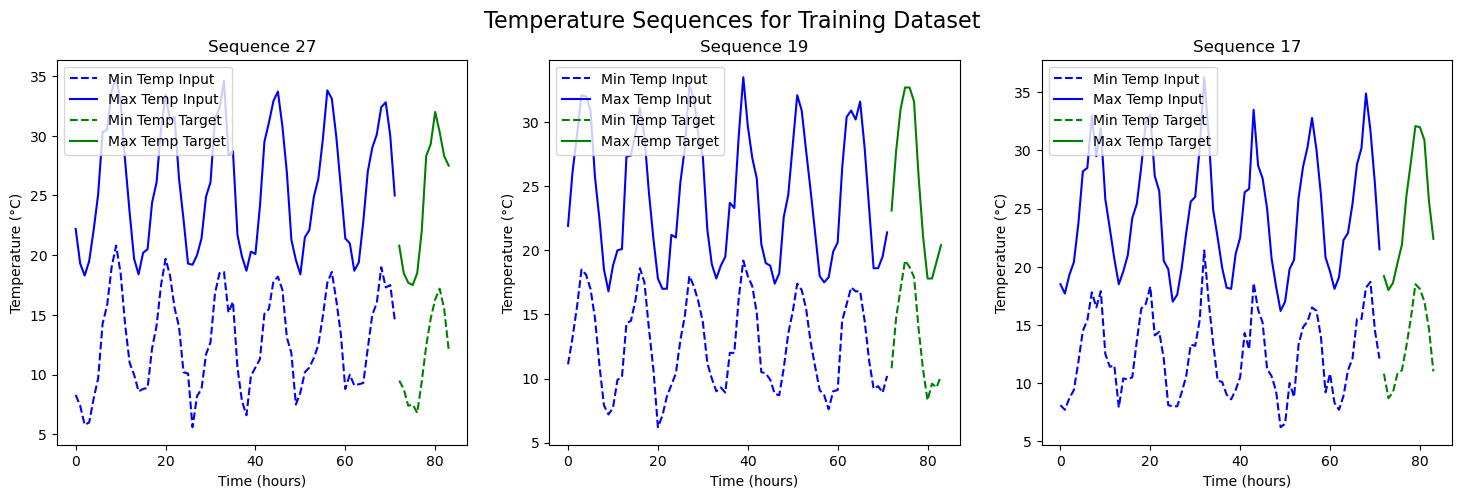

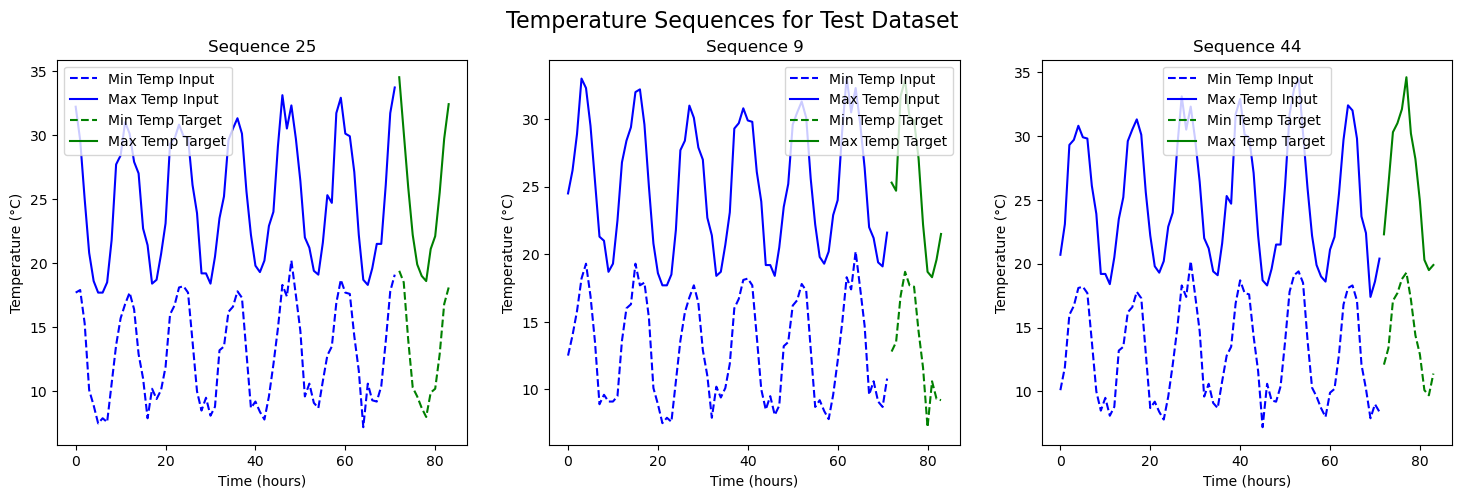

In [172]:
def display_temperatures(input, target, indices, pred=None, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Temperature Sequences for {title}', fontsize=16)

    for i, idx in enumerate(indices):
        input_range = range(0, inputs_length)
        target_range = range(inputs_length, inputs_length+targets_length)
        # min temp sequence in column 0, max temp sequence in column 1
        input_min = input[idx, :, 0]
        input_max = input[idx, :, 1]
        target_min = target[idx, :, 0]
        target_max = target[idx, :, 1]
        axes[i].plot(input_range, input_min, label="Min Temp Input", color='blue', linestyle='--')
        axes[i].plot(input_range, input_max, label="Max Temp Input", color='blue', linestyle='-')
        axes[i].plot(target_range, target_min, label="Min Temp Target", color='green', linestyle='--')
        axes[i].plot(target_range, target_max, label="Max Temp Target", color='green', linestyle='-')
        
        if pred is not None:
            pred_min = pred[idx, :, 0]
            pred_max = pred[idx, :, 1]
            axes[i].plot(target_range, pred_min, label="Min Temp Prediction", color='red', linestyle='--')
            axes[i].plot(target_range, pred_max, label="Max Temp Prediction", color='red', linestyle='-')
        
        axes[i].set_title(f"Sequence {idx}")
        axes[i].set_xlabel("Time (hours)")
        axes[i].set_ylabel("Temperature (°C)")
        axes[i].legend()

# Display 3 random sequences from the training dataset
for batch in train_ds.take(1):
    X_train, y_train = batch
    train_indices = random.sample(range(X_train.shape[0]), 3)
    display_temperatures(X_train, y_train, train_indices, title="Training Dataset")

# Display 3 random sequences from the test dataset
for batch in test_ds.take(1):
    X_test, y_test = batch
    test_indices = random.sample(range(X_test.shape[0]), 3)
    display_temperatures(X_test, y_test, test_indices, title="Test Dataset")

## (c) Model 1

### Train Model 1

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_62 (GRU)                    │ (None, 12, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_63 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000 (11.72 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

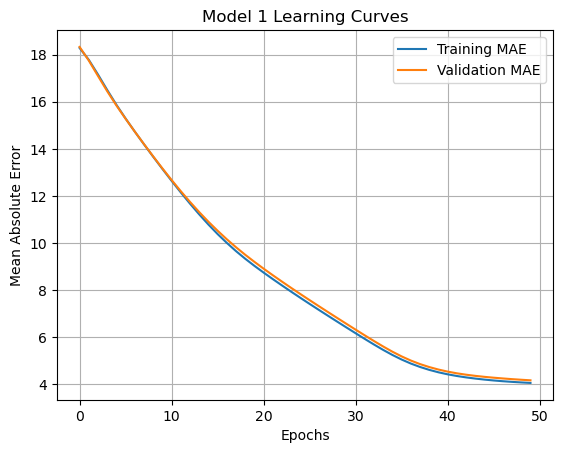

In [173]:
def create_model1(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='tanh', return_sequences=True),
        layers.GRU(16, activation='tanh'),
        layers.Dense(24),
        layers.Reshape((12, 2))
    ])
    return model

def train_model(model, train_ds, val_ds, epochs=50):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)
    return history

def plot_learning_curves(history, title):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{title} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid()
    plt.show()

model1 = create_model1(input_shape=(12, 2))
model1.summary()
history1 = train_model(model1, train_ds, val_ds)
plot_learning_curves(history1, "Model 1")

### Evaluate Model 1

Test MAE: 4.29


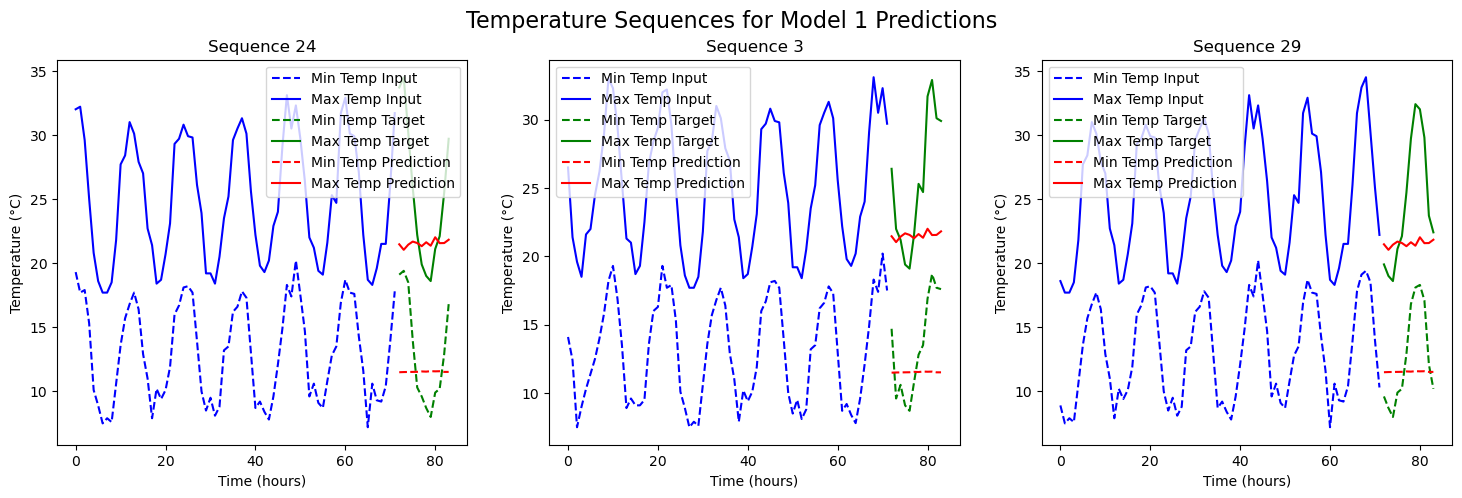

In [174]:
def evaluate_model(model, test_ds):
    _, test_mae = model.evaluate(test_ds, verbose=0)
    print(f"Test MAE: {test_mae:.2f}")

for batch in test_ds.take(1):
    X_test, y_test = batch
    evaluate_model(model1, test_ds)

    # Display 3 random sequences with predictions
    y_pred = model1.predict(X_test, verbose=0)
    sample_indices = random.sample(range(X_test.shape[0]), 3)
    display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 1 Predictions")

## (d) Model 2

### Train Model 2

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_64 (GRU)                    │ (None, 12, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_65 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

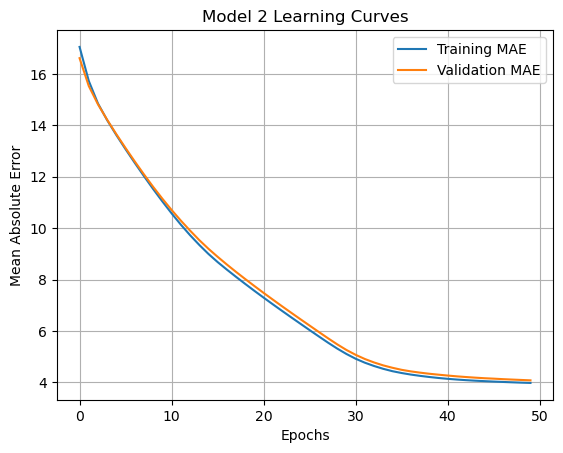

In [175]:
def create_model2(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='tanh', return_sequences=True),
        layers.GRU(16, activation='tanh'),
        layers.Dense(2)
    ])
    return model

train_ds_model2 = split_data_length(PerthA_df, (72, 1), train=True)
val_ds_model2 = split_data_length(PerthM_val, (72, 1))
test_ds_model2 = split_data_length(PerthM_test, (72, 1))

model2 = create_model2(input_shape=(12, 2))
model2.summary()
history2 = train_model(model2, train_ds_model2, val_ds_model2)
plot_learning_curves(history2, "Model 2")

### Evaluate Model 2

Test MAE: 4.21


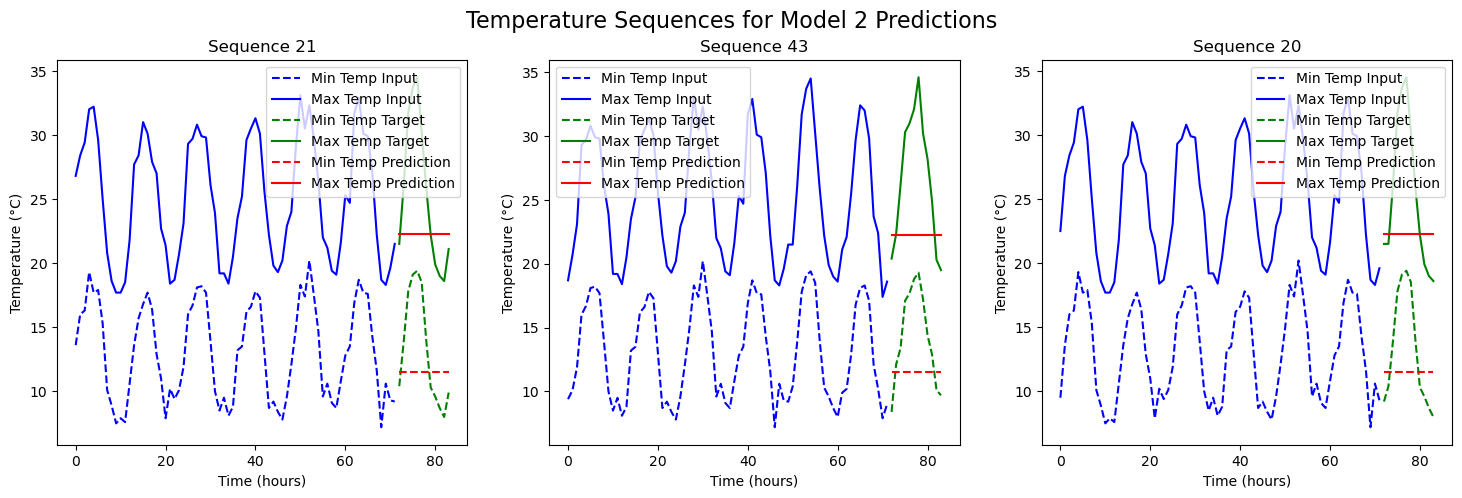

In [181]:
def predict_12months(model, input_X):
    X = input_X
    for step in range(12):
        y_pred_one = model.predict(X[:, step:], verbose=0)[:, np.newaxis, :]
        X = np.concatenate([X, y_pred_one], axis=1)
    y_pred = X[:, -12:, :]
    return np.array(y_pred)

def evaluate_model2(model, test_ds):
    mae_values = []
    for batch in test_ds.take(1):
        X_test, y_test = batch
        y_pred = predict_12months(model, X_test)
        mae = tf.keras.losses.MAE(y_test, y_pred).numpy()
        mae_values.append(mae)
    print(f"Test MAE: {np.mean(mae_values):.2f}")

for batch in test_ds.take(1):
    X_test, y_test = batch
    evaluate_model2(model2, test_ds_model2)
    y_pred = predict_12months(model2, X_test)
    sample_indices = random.sample(range(X_test.shape[0]), 3)
    display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (e) Model 3

In [177]:
def create_model3():
    pass


## (f) Comparison of Models for different Target Lengths

### Train all models for different target lengths

In [183]:
settings = [(72, 12), (66, 18), (60, 24), (54, 30), (48, 36)]
model_maes = {
    'Model 1': [],
    'Model 2': [],
    'Model 3': []
}

for input_length, target_length in settings:
    # Prepare datasets for the current setting
    train_ds = split_data_length(PerthA_df, (input_length, target_length), train=True)
    val_ds = split_data_length(PerthM_val, (input_length, target_length))
    test_ds = split_data_length(PerthM_test, (input_length, target_length))
    train_ds2 = split_data_length(PerthA_df, (input_length, 1), train=True)
    val_ds2 = split_data_length(PerthM_val, (input_length, 1))

    # Train and evaluate Model 1
    model_1 = create_model1((input_length, 2))
    train_model(model_1, train_ds, val_ds)
    mae_1 = evaluate_model(model_1, test_ds)
    model_maes['Model 1'].append(mae_1)

    # Train and evaluate Model 2
    model_2 = create_model2((input_length, 2))
    train_model(model_2, train_ds2, val_ds2)
    mae_2 = evaluate_model2(model_2, test_ds)
    model_maes['Model 2'].append(mae_2)

    # Train and evaluate Model 3
    model_3 = create_model3()
    # TODO
    mae_3 = 0  # TODO
    model_maes['Model 3'].append(mae_3)

Test MAE: 4.28
Test MAE: 4.21


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mae/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\allis\AppData\Local\Temp\ipykernel_34864\2621300914.py", line 19, in <module>

  File "C:\Users\allis\AppData\Local\Temp\ipykernel_34864\394606655.py", line 14, in train_model

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 70, in train_step

Incompatible shapes: [32,18,2] vs. [32,12,2]
	 [[{{node gradient_tape/compile_loss/mae/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_308154]

### Plot MAE against target lengths for all models

In [ ]:
plt.figure(figsize=(10, 6))
for model, maes in model_maes.items():
    plt.plot([length[1] for length in settings], maes, marker='o', label=model)
plt.title('MAE vs Target Length for Different Models')
plt.xlabel('Target Length (Months)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([12, 18, 24, 30, 36])
plt.legend()
plt.grid()
plt.show()

### Analysis

# Part 2 Tasks
Train a variational autoencoder (VAE) to synthesize temperature data.

In [184]:
# Reset the datasets
train_ds = split_data_length(PerthA_df, (72, 12), train=True)
val_ds = split_data_length(PerthM_val, (72, 12))
test_ds = split_data_length(PerthM_test, (72, 12))

In [189]:
# Define a customised layer
class Sampling(tf.keras.Layer):
    def call(self, inputs):
        mean, logvar = inputs
        # Define the latent loss and add it to the loss function
        latent_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.exp(logvar) - tf.square(mean), axis=-1) / 784.
        self.add_loss(latent_loss)
        return tf.random.normal(tf.shape(logvar)) * tf.exp(logvar / 2) + mean

def create_vae(input_shape, latent_dim):
    # Encoder part of the VAE
    inputs = layers.Input(shape=input_shape)
    Z = layers.Flatten()(inputs)
    Z = layers.Dense(150, activation="relu")(Z)
    Z = layers.Dense(100, activation="relu")(Z)
    codings_mean = tf.keras.layers.Dense(latent_dim)(Z) # mu
    codings_log_var = tf.keras.layers.Dense(latent_dim)(Z) # gamma
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

    # Decoder part of the VAE
    decoder_inputs = tf.keras.Input(shape=[latent_dim])
    x = layers.Dense(100, activation="relu")(decoder_inputs)
    x = layers.Dense(150, activation="relu")(x)
    x = layers.Dense(24)(x)
    outputs = layers.Reshape([12, 2])(x)
    variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)

    # Join encoder and decoder together to form VAE
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

    return variational_ae, variational_encoder, variational_decoder

# Create the VAE model
vae, encoder, decoder = create_vae(input_shape=(72, 2), latent_dim=10)
vae.compile(loss="mse", optimizer="nadam")
history = vae.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)
plot_learning_curves(history, "VAE")

InvalidArgumentError: Graph execution error:

Detected at node functional_52_1/functional_50_1/flatten_3_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\allis\AppData\Local\Temp\ipykernel_34864\2720803006.py", line 39, in <module>

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 318, in fit

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\ops\numpy.py", line 4440, in reshape

  File "c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_52_1/functional_50_1/flatten_3_1/Reshape}}]] [Op:__inference_one_step_on_iterator_315906]